In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist
np.random.seed(25)
tf.executing_eagerly()





False

### Iterative Functions Used:

In [2]:
# A function to compute the value of latent space using mu and sigma
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps


In [3]:

# The loss function for VAE
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)


In [4]:

# A function to display image sequence
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False, sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()


### Load the Images

In [5]:

# Loading dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()


### Plot few examples

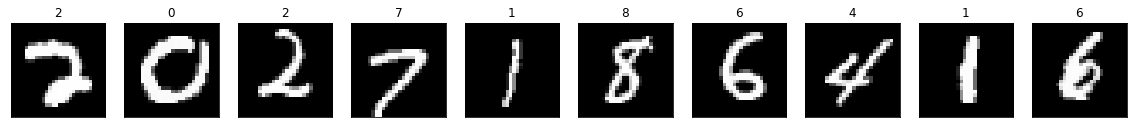

In [6]:
# Displaying 120th to 129th data
fig, axes = plt.subplots(ncols=10, sharex=False, sharey=True, figsize=(20, 7))
counter = 0
for i in range(120, 130):
    axes[counter].set_title(y_train[i])
    axes[counter].imshow(X_train[i], cmap='gray')
    axes[counter].get_xaxis().set_visible(False)
    axes[counter].get_yaxis().set_visible(False)
    counter += 1
plt.show()


In [7]:
# Normalize values such that all numbers are within
# the range of 0 to 1
X_train = X_train/255
X_test = X_test/255

# Convert from (no_of_data, 28, 28) to (no_of_data, 28, 28, 1)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Defining some variables
img_height   = X_train_new.shape[1]    # 28
img_width    = X_train_new.shape[2]    # 28
num_channels = X_train_new.shape[3]    # 1
input_shape =  (img_height, img_width, num_channels)   # (28,28,1)
latent_dim = 2    # Dimension of the latent space



### Define the encoder

In [8]:
# Constructing encoder
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2,padding='same', activation='relu')(encoder_input)
# encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)


### Define the Latent Space

In [9]:

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

# Take the convolution shape to be used in the decoder
conv_shape = K.int_shape(encoder_conv)


### Define the Decoder

In [10]:
# Constructing decoder
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)

decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)

# decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, padding='same', activation='sigmoid')(decoder_conv)



### Define the Model

In [11]:

# Actually build encoder, decoder and the entire VAE
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))



### Model Summary

In [12]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1568)         0           conv2d[0][0]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 2)            3138        flatten[0][0]                    
______________________________________________________________________________________________

In [13]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1568)              4704      
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         73        
Total params: 5,361
Trainable params: 5,361
Non-trainable params: 0
_________________________________________________________________


In [14]:
vae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 2)                 6356      
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         5361      
Total params: 11,717
Trainable params: 11,717
Non-trainable params: 0
_________________________________________________________________


In [15]:

# Compile the model using KL loss
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

# Training VAE
history = vae.fit(x=X_train_new, y=X_train_new, epochs=30, batch_size=32, validation_data=(X_test_new,X_test_new))


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
59904/60000 [============================>.] - ETA: 0s - loss: 196.7922

/home/praveen/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 7s 110us/sample - loss: 196.7544 - val_loss: 174.1376
Epoch 2/30
60000/60000 [==============================] - 6s 105us/sample - loss: 172.8652 - val_loss: 171.6555
Epoch 3/30
60000/60000 [==============================] - 6s 106us/sample - loss: 170.3584 - val_loss: 169.0581
Epoch 4/30
60000/60000 [==============================] - 6s 106us/sample - loss: 168.1558 - val_loss: 167.4829
Epoch 5/30
60000/60000 [==============================] - 6s 105us/sample - loss: 166.9209 - val_loss: 166.4000
Epoch 6/30
60000/60000 [==============================] - 6s 106us/sample - loss: 166.1951 - val_loss: 165.8548
Epoch 7/30
60000/60000 [==============================] - 6s 105us/sample - loss: 165.7532 - val_loss: 165.6428
Epoch 8/30
60000/60000 [==============================] - 6s 106us/sample - loss: 165.4079 - val_loss: 165.4244
Epoch 9/30
60000/60000 [==============================] - 6s 106us/sample - loss: 165.1285 - val_loss: 164.9625
Epo

In [16]:

# A function to display image sequence
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
   
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False, sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()


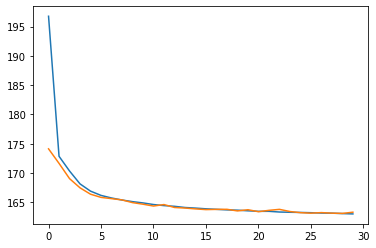

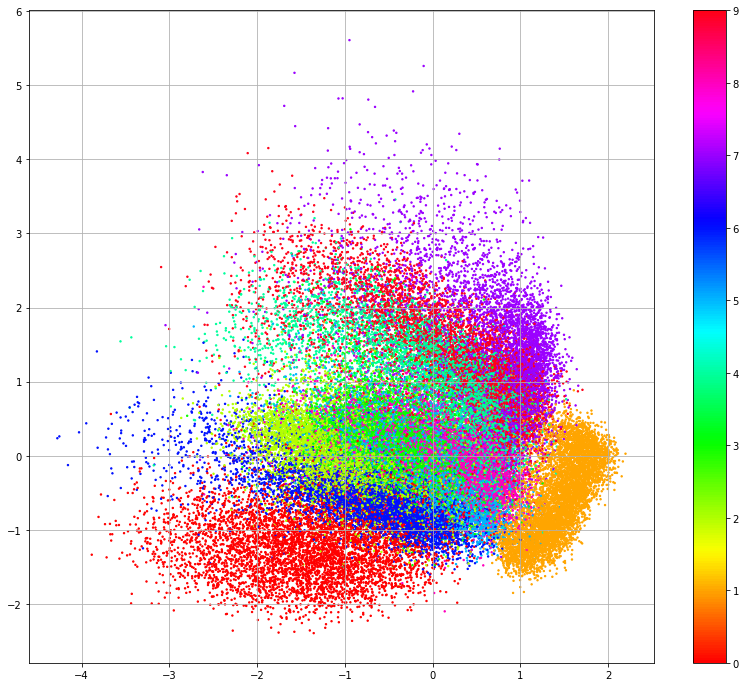

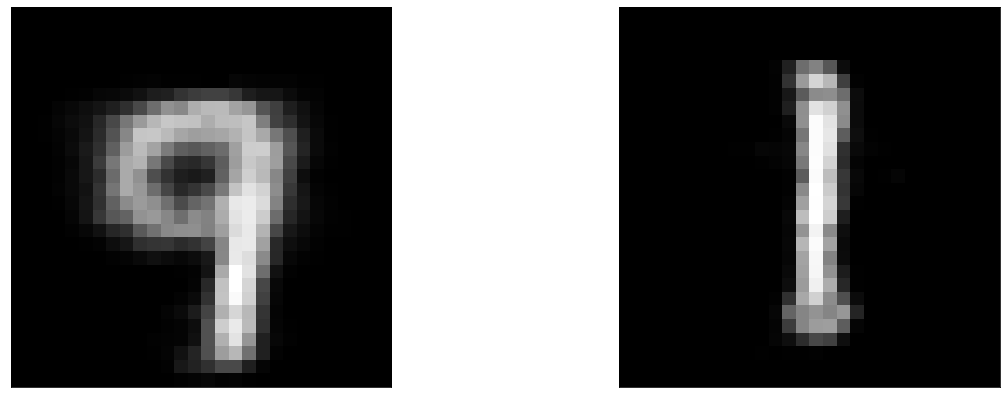

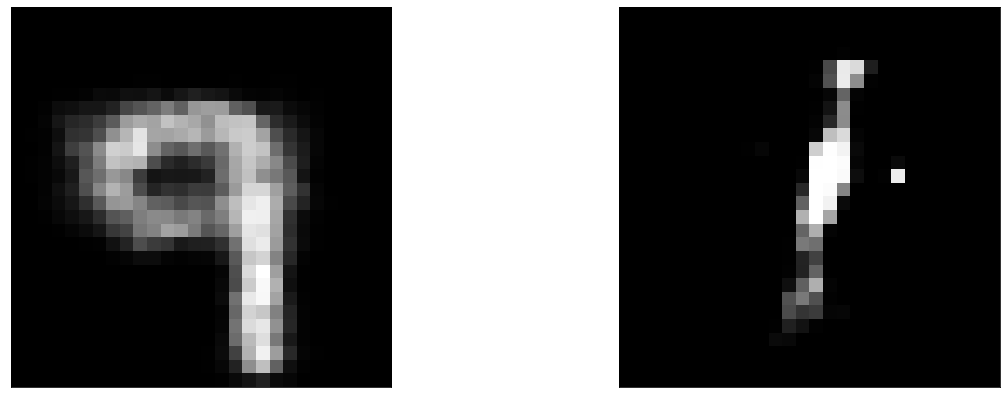

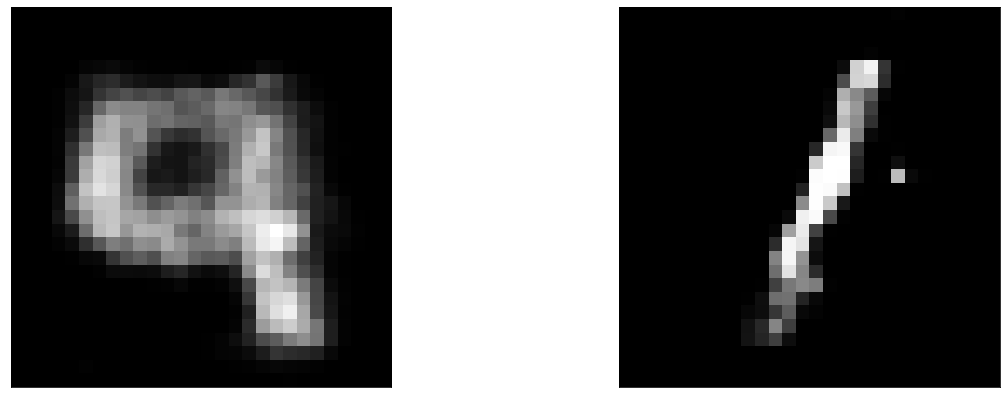

In [17]:

# Plotting loss value decrease
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Transform images to points in latent space using encoder
encoded = encoder.predict(X_train_new)

# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()
plt.grid()
plt.show()

# Displaying several new images
# Starting point=(0,2), end point=(2,0)
display_image_sequence(0,2,2,0,2)

# Starting point=(-2,1), end point=(0,2)
display_image_sequence(-1,3,3,-1,2)


display_image_sequence(-2,2,2,-2,2)



In [26]:
x_start, y_start, x_end, y_end, no_of_imgs = 0,2,2,0,2

x_axis = np.linspace(x_start,x_end,no_of_imgs)
y_axis = np.linspace(y_start,y_end,no_of_imgs)

x_axis = x_axis[:, np.newaxis]
y_axis = y_axis[:, np.newaxis]



new_points = np.hstack((x_axis, y_axis))

In [37]:
np.linspace(0,2,4)

array([0.        , 0.66666667, 1.33333333, 2.        ])

In [35]:
np.linspace(0,4,8)

array([0.        , 0.57142857, 1.14285714, 1.71428571, 2.28571429,
       2.85714286, 3.42857143, 4.        ])

In [43]:
x_axis = x_axis[:, np.newaxis]

(2, 1, 1)

In [51]:
np.hstack((x_axis, y_axis)).shape

(2, 2)

In [59]:
np.hstack(np.array([[1,2],[3,4]]))

array([1, 2, 3, 4])

In [57]:
np.array([[1,2],[3,4]]).shape

(2, 2)

In [58]:
new_points

array([[0., 2.],
       [2., 0.]])